In [1]:
from functions0 import *
import numpy as np
import datetime
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter
from qiskit import Aer, assemble, QuantumCircuit, QuantumRegister, ClassicalRegister, IBMQ, transpile, execute
from qiskit.providers.aer import AerSimulator, QasmSimulator
from qiskit.opflow import Zero, One, I, X, Y, Z
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info import state_fidelity
import matplotlib.pyplot as plt
import qiskit.ignis.mitigation.measurement as mc
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science-22')

backend_sim_jakarta = QasmSimulator.from_backend(provider.get_backend('ibmq_jakarta'))
backend_real_jakarta = provider.get_backend('ibmq_jakarta')
backend_sim = Aer.get_backend('qasm_simulator')

In [2]:
n_steps=51
time=np.pi
initial_state="110" #{"110": 1}
reps = 1
shots = 32000
backend = backend_sim_jakarta
precision=50

In [3]:
numeric_evolution_matrix = eye(8)

for _ in range(n_steps): # here is computed the evolution operator numerically, with n_steps trotter steps.
    numeric_evolution_matrix=(numeric_evolution_matrix*trotter_step_matrix(time/n_steps)).evalf(precision)

# here are computed the parameters of the gates as described in "decomposition.ipynb" file.
phase_1_1, phase_2_1, phase_1_2, phase_2_2, a1, a2 = get_gates_parameters(initial_state=initial_state, U=numeric_evolution_matrix)

M1_qc = fixed_magnetization_two_qubit_gate(phase_1_1,phase_1_2,a1)
M2_qc = fixed_magnetization_two_qubit_gate(phase_2_1,phase_2_2,a2)

metti apposto lo stato iniziale!
6
2


In [4]:
numeric_evolution_matrix.evalf(6)

Matrix([
[-0.5 - 0.866025*I,                          0,                          0,                         0,                         0,                          0,                          0,                 0],
[                0,      0.249941 - 0.432969*I,  0.00457239 - 0.00797746*I,                         0,    -0.754514 - 0.425079*I,                          0,                          0,                 0],
[                0, -0.00458867 + 0.00788995*I,     -0.499984 - 0.865938*I,                         0, 0.00457239 - 0.00797746*I,                          0,                          0,                 0],
[                0,                          0,                          0,     0.249941 - 0.432969*I,                         0, -0.00458867 + 0.00788995*I,     -0.745353 - 0.440947*I,                 0],
[                0,     -0.745353 - 0.440947*I, -0.00458867 + 0.00788995*I,                         0,     0.249941 - 0.432969*I,                          0,          

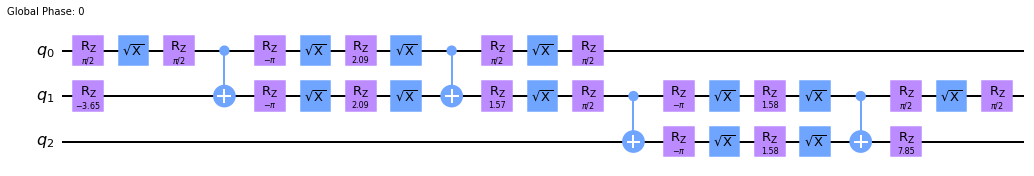

In [5]:
qr3 = QuantumRegister(3 ,name="q")
qc3 = QuantumCircuit(qr3, name="U")

qc3.append(M1_qc, [qr3[0],qr3[1]])
qc3.append(M2_qc, [qr3[1],qr3[2]])

qc3=transpile(qc3, basis_gates=["cx","rz","x","sx"])
qc3.draw(output="mpl")

In [6]:
backend_ = Aer.get_backend('unitary_simulator')
job = execute(qc3, backend_, shots=32000)
result = job.result()
A=result.get_unitary(qc3, decimals=10)
Matrix(A)

Matrix([
[0.4999498877 + 0.8660543342*I,                              0,                              0,                              0,                              0,                              0,                              0,                             0],
[                            0,  0.2499411216 + 0.4329685774*I,  0.7453938516 + 0.4409712607*I,                              0,                              0,                              0,                              0,                             0],
[                            0,  0.0045886651 + 0.0078899452*I, -0.0045432193 - 0.0026679896*I,                              0, -0.4999221231 - 0.8660062383*I,                              0,                              0,                             0],
[                            0,                              0,                              0, -0.0090876681 - 0.0053367013*I,                              0, -0.2499272412 - 0.4329445327*I, -0.7453524564 - 0.4409467716*I,

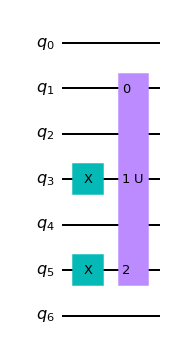

In [7]:
qr = QuantumRegister(7 ,name="q")
qc = QuantumCircuit(qr, name="U")


l=0
for k in [5,3,1]:
    if initial_state[l]=='1':
        qc.x(qr[k])
    l+=1

qc.append(qc3, [qr[1],qr[3],qr[5]])

qc.draw(output="mpl")

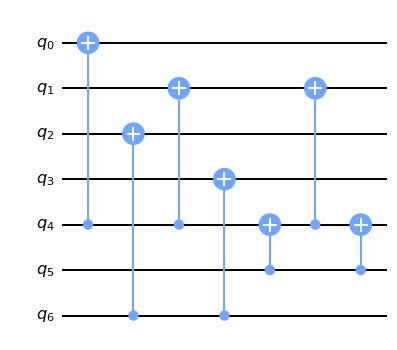

In [8]:
qc_check=symmetry_check(type="4copy_check")
qc_check.draw(output="mpl")

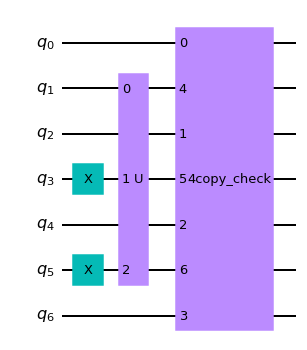

In [9]:
qc=add_symmetry_check(qc, [qr[1],qr[3],qr[5]], [qr[0],qr[2],qr[4],qr[6]], type="4copy_check")
qc.draw(output="mpl")

In [10]:
qcs_tomo = state_tomography_circuits(qc, [qr[1],qr[3],qr[5]])
qcs_na = state_tomography_circuits(qc, [qr[1],qr[3],qr[5]]) #cirquits without ancillas measurament for the fidelity computation

for qc_iter in qcs_tomo:
    qc_iter.barrier()
    cr_anc=ClassicalRegister(4)
    qc_iter.add_register(cr_anc)
    qc_iter.measure([qr[0],qr[2],qr[4],qr[6]], cr_anc)

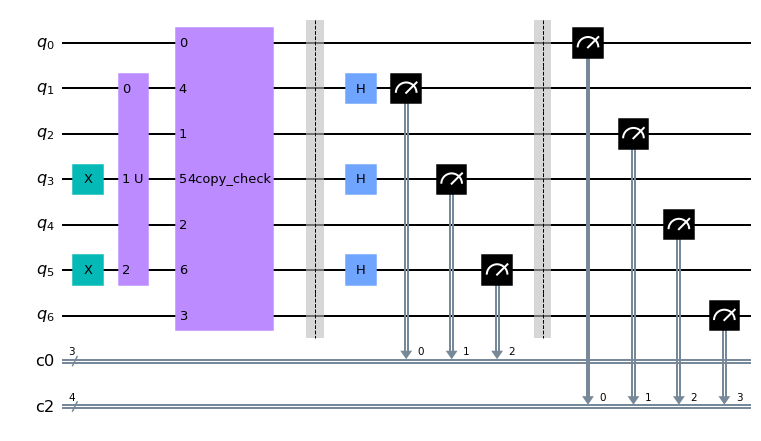

In [11]:
qcs_tomo[0].draw(output="mpl")

In [12]:
qr_cal = QuantumRegister(7)
cal_circ, state_labels = mc.complete_meas_cal(qubit_list=[1,3,5,0,2,4,6], qr=qr_cal, circlabel='mcal') #[1,3,5,0,2,4]


In [13]:
cal_circ[1].draw()

░          ┌─┐         
q35_0: ──────░──────────┤M├─────────
       ┌───┐ ░ ┌─┐      └╥┘         
q35_1: ┤ X ├─░─┤M├───────╫──────────
       └───┘ ░ └╥┘       ║ ┌─┐      
q35_2: ──────░──╫────────╫─┤M├──────
             ░  ║ ┌─┐    ║ └╥┘      
q35_3: ──────░──╫─┤M├────╫──╫───────
             ░  ║ └╥┘    ║  ║ ┌─┐   
q35_4: ──────░──╫──╫─────╫──╫─┤M├───
             ░  ║  ║ ┌─┐ ║  ║ └╥┘   
q35_5: ──────░──╫──╫─┤M├─╫──╫──╫────
             ░  ║  ║ └╥┘ ║  ║  ║ ┌─┐
q35_6: ──────░──╫──╫──╫──╫──╫──╫─┤M├
             ░  ║  ║  ║  ║  ║  ║ └╥┘
c29: 7/═════════╩══╩══╩══╩══╩══╩══╩═
                0  1  2  3  4  5  6

In [14]:
qcs_calib_itself, meas_calibs = calibration_cirquits("itself", q_anc=[0,2,4,6], N=n_steps, time=time, check="yes", check_type="4copy_check")


cambiare initial_state e time
metti apposto lo stato iniziale!
6
2
aggiustare questa cosa delle x nel check
aggiustare questa cosa delle x nel check
aggiustare questa cosa delle x nel check
aggiustare questa cosa delle x nel check
aggiustare questa cosa delle x nel check
aggiustare questa cosa delle x nel check
aggiustare questa cosa delle x nel check
aggiustare questa cosa delle x nel check
aggiustare questa cosa delle x nel check
aggiustare questa cosa delle x nel check
aggiustare questa cosa delle x nel check
aggiustare questa cosa delle x nel check
aggiustare questa cosa delle x nel check
aggiustare questa cosa delle x nel check
aggiustare questa cosa delle x nel check
aggiustare questa cosa delle x nel check
aggiustare questa cosa delle x nel check
aggiustare questa cosa delle x nel check
aggiustare questa cosa delle x nel check
aggiustare questa cosa delle x nel check
aggiustare questa cosa delle x nel check
aggiustare questa cosa delle x nel check
aggiustare questa cosa delle x 

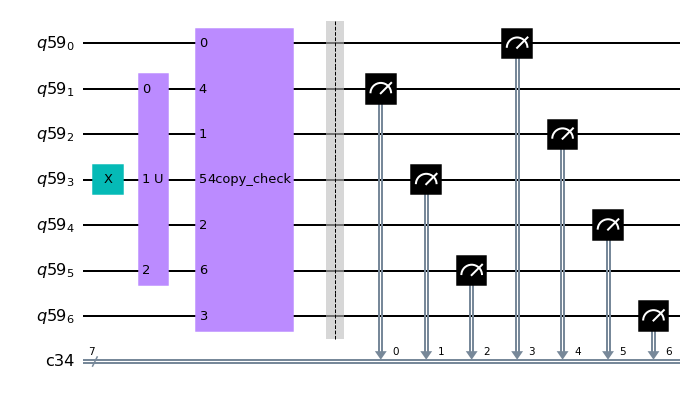

In [15]:
qcs_calib_itself[2].draw(output="mpl")

In [16]:
qcs_calibs_identity, meas_calibs = calibration_cirquits("column_evolution_remake2", q_anc=[0,2,4,6], N=n_steps, time=time, check="yes", check_type="4copy_check")
state_lables = bin_list(7)

cambiare initial_state e time
metti apposto lo stato iniziale!
6
2
aggiustare questa cosa delle x nel check
aggiustare questa cosa delle x nel check
aggiustare questa cosa delle x nel check
aggiustare questa cosa delle x nel check
aggiustare questa cosa delle x nel check
aggiustare questa cosa delle x nel check
aggiustare questa cosa delle x nel check
aggiustare questa cosa delle x nel check
aggiustare questa cosa delle x nel check
aggiustare questa cosa delle x nel check
aggiustare questa cosa delle x nel check
aggiustare questa cosa delle x nel check
aggiustare questa cosa delle x nel check
aggiustare questa cosa delle x nel check
aggiustare questa cosa delle x nel check
aggiustare questa cosa delle x nel check
aggiustare questa cosa delle x nel check
aggiustare questa cosa delle x nel check
aggiustare questa cosa delle x nel check
aggiustare questa cosa delle x nel check
aggiustare questa cosa delle x nel check
aggiustare questa cosa delle x nel check
aggiustare questa cosa delle x 

In [17]:
meas_calibs[1].draw()

░          ┌─┐         
q458_0: ──────░──────────┤M├─────────
        ┌───┐ ░ ┌─┐      └╥┘         
q458_1: ┤ X ├─░─┤M├───────╫──────────
        └───┘ ░ └╥┘       ║ ┌─┐      
q458_2: ──────░──╫────────╫─┤M├──────
              ░  ║ ┌─┐    ║ └╥┘      
q458_3: ──────░──╫─┤M├────╫──╫───────
              ░  ║ └╥┘    ║  ║ ┌─┐   
q458_4: ──────░──╫──╫─────╫──╫─┤M├───
              ░  ║  ║ ┌─┐ ║  ║ └╥┘   
q458_5: ──────░──╫──╫─┤M├─╫──╫──╫────
              ░  ║  ║ └╥┘ ║  ║  ║ ┌─┐
q458_6: ──────░──╫──╫──╫──╫──╫──╫─┤M├
              ░  ║  ║  ║  ║  ║  ║ └╥┘
c289: 7/═════════╩══╩══╩══╩══╩══╩══╩═
                 0  1  2  3  4  5  6

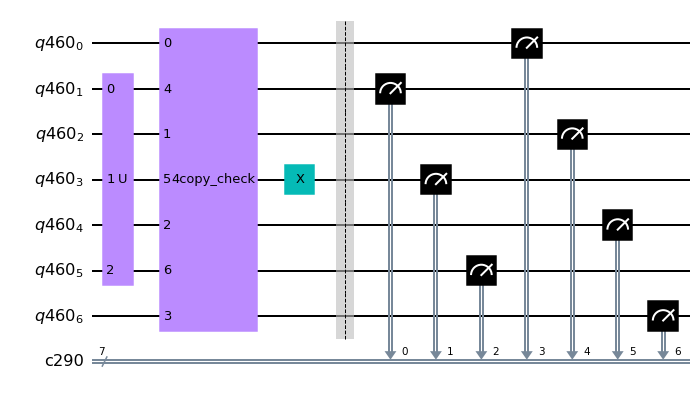

In [18]:
qcs_calibs_identity[2].draw(output="mpl")

In [19]:
jobs_evo=execute(qcs_tomo, backend=backend, shots=shots)
job_cal_our_identity=execute(qcs_calibs_identity, backend=backend, shots=shots)
job_cal_our_itself_new=execute(qcs_calib_itself, backend = backend, shots=shots)
job_cal=execute(meas_calibs, backend=backend, shots=shots)

In [29]:
meas_fitter_our = CompleteMeasFitter(job_cal_our_identity.result(), state_labels=state_lables)
meas_fitter = CompleteMeasFitter(job_cal.result(), state_labels=state_lables)

U_tilde=meas_fitter_our.cal_matrix

# da qui in poi non ti fidare (quasi) di niente

In [30]:
qr_basi = QuantumRegister(7)
qc_basi = QuantumCircuit(qr_basi)

#qc_basi.swap(5,4)
#qc_basi.swap(5,2)
#qc_basi.swap(1,3)
#qc_basi.swap(0,1)

qcs_basi = state_tomography_circuits(qc_basi,[qr_basi[0],qr_basi[1],qr_basi[2]])

'''
qr_aus = QuantumRegister(7 ,name="q")
qc_aus = QuantumCircuit(qr_aus, name="U")

qc_aus.append(qc3, [qr_aus[0],qr_aus[1],qr_aus[2]])
qc_aus=add_symmetry_check(qc_aus, [qr_aus[0],qr_aus[1],qr_aus[2]], [qr_aus[3],qr_aus[4],qr_aus[5],qr_aus[6]], type="4copy_check")

U = matrix_from_cirquit(qc_aus, type="numpy")

C_matrices = []
C= np.matmul(U_tilde, np.asarray(np.matrix(U).getH()))
'''
C_matrices = []
C=U_tilde

for qca in qcs_basi:
    
    qca.remove_final_measurements()

    #qca.swap(0,1)
    #qca.swap(1,3)
    #qca.swap(5,2)
    #qca.swap(5,4)

    qca_matrix = np.matrix(matrix_from_cirquit(qca, type="numpy"))
    qca_matrixH = qca_matrix.getH()

    C_aus = np.matmul(qca_matrix, np.matmul(C, qca_matrixH))

    C_matrices.append(np.asarray(C_aus))

In [31]:
from copy import deepcopy
meas_fitter_ours = []

for C_new in C_matrices:
    meas_fitter_our_aus = deepcopy(meas_fitter_our)
    meas_fitter_our_aus._tens_fitt.cal_matrices[0]=C_new

    meas_fitter_ours.append(meas_fitter_our_aus)



In [32]:
reps=1

target_state = (One^One^Zero).to_matrix()

fids=np.zeros([reps,4])
fids_mean=np.zeros(4)
fids_dev=np.zeros(4)

for j in range(reps):
    
    #res = jobs_evo_result[j]
    res=jobs_evo.result()

    print(j)
    
    new_res, new_res_nm = mitigate2(res, ancillas_conditions=['0011','1110','1101'], meas_fitter=meas_fitter)
    new_res_our, new_res_nm = mitigate2(res, ancillas_conditions=['0011','1110','1101'], meas_fitter=meas_fitter_ours)
    new_res_not_mitigated = mitigate2(res, ancillas_conditions=bin_list(4))

    fids[j,0] = fidelity_count(new_res_not_mitigated, qcs_na, target_state)
    fids[j,1] = fidelity_count(new_res_nm, qcs_na, target_state)
    fids[j,2] = fidelity_count(new_res, qcs_na, target_state)
    fids[j,3] = fidelity_count(new_res_our, qcs_na, target_state)

for i in range(4):
    fids_mean[i]=np.mean(fids[:,i])
    fids_dev[i]=np.std(fids[:,i])

0
0
tens_fitt
1
tens_fitt
2
tens_fitt
3
tens_fitt
4
tens_fitt
5
tens_fitt
6
tens_fitt
7
tens_fitt
8
tens_fitt
9
tens_fitt
10
tens_fitt
11
tens_fitt
12
tens_fitt
13
tens_fitt
14
tens_fitt
15
tens_fitt
16
tens_fitt
17
tens_fitt
18
tens_fitt
19
tens_fitt
20
tens_fitt
21
tens_fitt
22
tens_fitt
23
tens_fitt
24
tens_fitt
25
tens_fitt
26
tens_fitt
0
0 (128, 128)
deepcopy
1
1 (128, 128)
deepcopy
2
2 (128, 128)
deepcopy
3
3 (128, 128)
deepcopy
4
4 (128, 128)
deepcopy
5
5 (128, 128)
deepcopy
6
6 (128, 128)
deepcopy
7
7 (128, 128)
deepcopy
8
8 (128, 128)
deepcopy
9
9 (128, 128)
deepcopy
10
10 (128, 128)
deepcopy
11
11 (128, 128)
deepcopy
12
12 (128, 128)
deepcopy
13
13 (128, 128)
deepcopy
14
14 (128, 128)
deepcopy
15
15 (128, 128)
deepcopy
16
16 (128, 128)
deepcopy
17
17 (128, 128)
deepcopy
18
18 (128, 128)
deepcopy
19
19 (128, 128)
deepcopy
20
20 (128, 128)
deepcopy
21
21 (128, 128)
deepcopy
22
22 (128, 128)
deepcopy
23
23 (128, 128)
deepcopy
24
24 (128, 128)
deepcopy
25
25 (128, 128)
deepcopy
2

In [24]:
np.log2(10000000000000)

43.18506523353571

In [33]:
fids_mean

array([0.21685938, 0.21993003, 0.24716274, 0.24281145])

In [34]:
def H_heis3():
    # Interactions (I is the identity matrix; X, Y, and Z are Pauli matricies; ^ is a tensor product)
    XXs = (I^X^X) + (X^X^I)
    YYs = (I^Y^Y) + (Y^Y^I)
    ZZs = (I^Z^Z) + (Z^Z^I)
    
    # Sum interactions
    H = XXs + YYs + ZZs
    
    # Return Hamiltonian
    return H

def U_heis3(t):
    # Compute XXX Hamiltonian for 3 spins in a line
    H = H_heis3()
    
    # Return the exponential of -i multipled by time t multipled by the 3 spin XXX Heisenberg Hamilonian 
    return (t * H).exp_i()

In [35]:
initial_state = One^One^Zero
target_state2 = One^One^Zero

trueval = np.abs((~target_state2 @ U_heis3(float(time)) @ initial_state).eval())**2

In [36]:
print(abs(trueval-fids_mean))

[0.03314062 0.03006997 0.00283726 0.00718855]
